## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import os
plt.style.use('dark_background')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.cuda.current_device()

0

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

We also should split our test dataset into test and validation datasets 

In [4]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [5]:
val_size = 0.2
val_inds = subset_ind(fmnist_dataset_test, val_size)

train_dataset = Subset(fmnist_dataset_test, [i for i in range(len(fmnist_dataset_test)) if i not in val_inds])
val_dataset = Subset(fmnist_dataset_test, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 8000
validation size: 2000


In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=8000,
                                          shuffle=False,
                                          num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=2)

In [9]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([128, 1, 28, 28])
labels shape on batch size = torch.Size([128])


In [10]:
len(fmnist_dataset_test)

10000

In [26]:
test_loader.sampler

In [11]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape*2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(input_shape*2, input_shape*2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(input_shape*2, num_classes)           
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [14]:
torchsummary.summary(model.to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
           Dropout-3                 [-1, 1568]               0
              ReLU-4                 [-1, 1568]               0
            Linear-5                 [-1, 1568]       2,460,192
           Dropout-6                 [-1, 1568]               0
              ReLU-7                 [-1, 1568]               0
            Linear-8                   [-1, 10]          15,690
Total params: 3,706,762
Trainable params: 3,706,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 14.14
Estimated Total Size (MB): 14.22
----------------------------------------------------------------


Your experiments come here:

In [40]:
input_shape = 28*28
num_classes = 10
model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(input_shape, input_shape//2),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(input_shape//2, num_classes),
            nn.LogSoftmax()
        )
model.to(device, torch.float32)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=784, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=784, out_features=392, bias=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): ReLU()
  (7): Linear(in_features=392, out_features=10, bias=True)
  (8): LogSoftmax(dim=None)
)

In [7]:
import time
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)


                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]### YOUR CODE HERE
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [8]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [41]:
#model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 24.450s
	  training loss: 0.565955
	validation loss: 0.408138
	validation accuracy: 0.858
Epoch 2 of 30 took 21.463s
	  training loss: 0.407463
	validation loss: 0.395408
	validation accuracy: 0.858
Epoch 3 of 30 took 24.038s
	  training loss: 0.373449
	validation loss: 0.364181
	validation accuracy: 0.871
Epoch 4 of 30 took 23.940s
	  training loss: 0.352309
	validation loss: 0.334330
	validation accuracy: 0.884
Epoch 5 of 30 took 20.794s
	  training loss: 0.332356
	validation loss: 0.328402
	validation accuracy: 0.881
Epoch 6 of 30 took 19.985s
	  training loss: 0.322158
	validation loss: 0.319569
	validation accuracy: 0.886
Epoch 7 of 30 took 21.065s
	  training loss: 0.310818
	validation loss: 0.302325
	validation accuracy: 0.890
Epoch 8 of 30 took 20.864s
	  training loss: 0.305152
	validation loss: 0.290752
	validation accuracy: 0.892
Epoch 9 of 30 took 23.035s
	  training loss: 0.294777
	validation loss: 0.307087
	validation accuracy: 0.887
Epoch 10 of 30 took

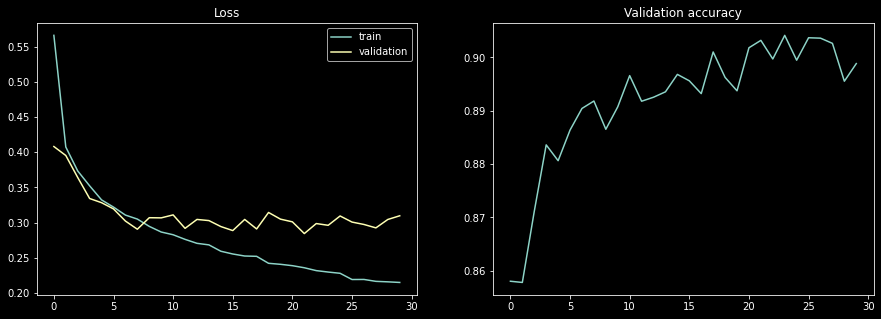

In [42]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [44]:
model.train(False)
from sklearn.metrics import accuracy_score
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    out = model(X_batch)
    y_pred = out.max(dim=1)[1].cpu()
    print('accuracy on test: ', accuracy_score(y_pred, y_batch))


accuracy on test:  0.894125


We reached desired accuracy score $\geq 0.885$, but from plot above we can see, that our model started overfitting

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [10]:
input_shape = 28*28
num_classes = 10
overfitted_model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape*2),
            nn.ReLU(),
            nn.Linear(input_shape*2, input_shape*2),
            nn.ReLU(),
            nn.Linear(input_shape*2, num_classes),
            nn.LogSoftmax()
        )
overfitted_model.to(device, torch.float32)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=1568, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1568, out_features=1568, bias=True)
  (4): ReLU()
  (5): Linear(in_features=1568, out_features=10, bias=True)
  (6): LogSoftmax(dim=None)
)

In [11]:
torchsummary.summary(overfitted_model.to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
              ReLU-3                 [-1, 1568]               0
            Linear-4                 [-1, 1568]       2,460,192
              ReLU-5                 [-1, 1568]               0
            Linear-6                   [-1, 10]          15,690
        LogSoftmax-7                   [-1, 10]               0
Total params: 3,706,762
Trainable params: 3,706,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 14.14
Estimated Total Size (MB): 14.20
----------------------------------------------------------------


C:\Users\maxim\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [13]:
opt = torch.optim.Adam(overfitted_model.parameters(), lr=1e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

n_epochs = 30
# Your experiments, come here
train_loss, val_loss, val_accuracy = train_model(overfitted_model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 23.183s
	  training loss: 0.477748
	validation loss: 0.395061
	validation accuracy: 0.848
Epoch 2 of 30 took 21.413s
	  training loss: 0.356957
	validation loss: 0.355478
	validation accuracy: 0.870
Epoch 3 of 30 took 21.201s
	  training loss: 0.321386
	validation loss: 0.349137
	validation accuracy: 0.870
Epoch 4 of 30 took 23.715s
	  training loss: 0.294639
	validation loss: 0.332289
	validation accuracy: 0.876
Epoch 5 of 30 took 23.695s
	  training loss: 0.272944
	validation loss: 0.309263
	validation accuracy: 0.884
Epoch 6 of 30 took 21.368s
	  training loss: 0.256967
	validation loss: 0.317047
	validation accuracy: 0.887
Epoch 7 of 30 took 22.039s
	  training loss: 0.245977
	validation loss: 0.318827
	validation accuracy: 0.882
Epoch 8 of 30 took 21.717s
	  training loss: 0.229842
	validation loss: 0.311972
	validation accuracy: 0.888
Epoch 9 of 30 took 21.913s
	  training loss: 0.220458
	validation loss: 0.317011
	validation accuracy: 0.886
Epoch 10 of 30 took

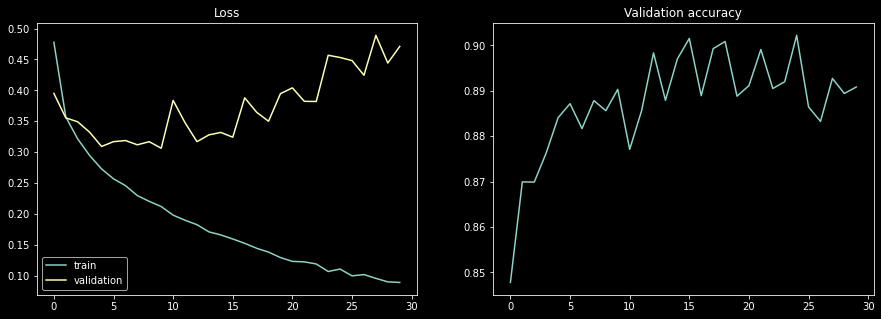

In [14]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [16]:
overfitted_model.train(False)
from sklearn.metrics import accuracy_score
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    out = overfitted_model(X_batch)
    y_pred = out.max(dim=1)[1].cpu()
    print('accuracy on test: ', accuracy_score(y_pred, y_batch))

C:\Users\maxim\anaconda3\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


accuracy on test:  0.889625


From our last two plots, we could notice a significant model overfitting, so that our train loss is decreasing, but validation score is rising up

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [67]:
input_shape = 28*28
num_classes = 10
fixed_model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(p=0.5),        
            nn.Linear(input_shape, input_shape*2),
            nn.BatchNorm1d(input_shape*2, momentum=0.8),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(input_shape*2, input_shape*2),
            nn.BatchNorm1d(input_shape*2, momentum=0.8),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(input_shape*2, num_classes),
            nn.LogSoftmax()
        )
fixed_model.to(device, torch.float32)

Sequential(
  (0): Flatten()
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=784, out_features=1568, bias=True)
  (3): BatchNorm1d(1568, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1568, out_features=1568, bias=True)
  (7): BatchNorm1d(1568, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Dropout(p=0.4, inplace=False)
  (10): Linear(in_features=1568, out_features=10, bias=True)
  (11): LogSoftmax(dim=None)
)

In [68]:
torchsummary.summary(fixed_model.to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                 [-1, 1568]       1,230,880
       BatchNorm1d-4                 [-1, 1568]           3,136
              ReLU-5                 [-1, 1568]               0
           Dropout-6                 [-1, 1568]               0
            Linear-7                 [-1, 1568]       2,460,192
       BatchNorm1d-8                 [-1, 1568]           3,136
              ReLU-9                 [-1, 1568]               0
          Dropout-10                 [-1, 1568]               0
           Linear-11                   [-1, 10]          15,690
       LogSoftmax-12                   [-1, 10]               0
Total params: 3,713,034
Trainable params: 3,713,034
Non-trainable params: 0
---------------------------

In [71]:
loss_func = nn.NLLLoss() # YOUR CODE HERE
n_epochs = 50
opt = torch.optim.Adam(fixed_model.parameters(), lr=1e-3) 
train_loss, val_loss, val_accuracy = train_model(fixed_model, train_loader, val_loader, loss_func, opt, n_epochs)

# Your experiments, come here

Epoch 1 of 50 took 23.334s
	  training loss: 0.410392
	validation loss: 0.336401
	validation accuracy: 0.869
Epoch 2 of 50 took 20.283s
	  training loss: 0.404063
	validation loss: 0.348646
	validation accuracy: 0.867
Epoch 3 of 50 took 20.640s
	  training loss: 0.397409
	validation loss: 0.350201
	validation accuracy: 0.870
Epoch 4 of 50 took 24.583s
	  training loss: 0.389661
	validation loss: 0.340242
	validation accuracy: 0.871
Epoch 5 of 50 took 23.411s
	  training loss: 0.385221
	validation loss: 0.337621
	validation accuracy: 0.881
Epoch 6 of 50 took 24.592s
	  training loss: 0.383844
	validation loss: 0.327897
	validation accuracy: 0.872
Epoch 7 of 50 took 22.722s
	  training loss: 0.380601
	validation loss: 0.327914
	validation accuracy: 0.879
Epoch 8 of 50 took 24.911s
	  training loss: 0.378776
	validation loss: 0.327309
	validation accuracy: 0.873
Epoch 9 of 50 took 23.610s
	  training loss: 0.370498
	validation loss: 0.321567
	validation accuracy: 0.874
Epoch 10 of 50 took

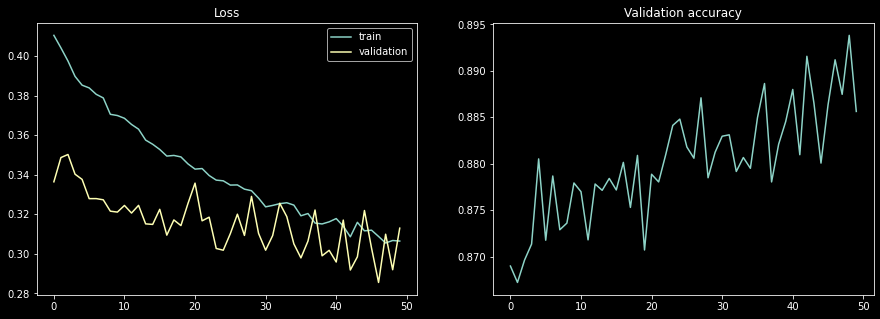

In [72]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [73]:
for X_batch, y_batch in test_loader:
    X_batch= X_batch.to(device)
    out = fixed_model(X_batch)
    y_pred = out.max(dim=1)[1].cpu()
    print('accuracy on test: ', accuracy_score(y_pred, y_batch))

accuracy on test:  0.880125


### Conclusions:
_Write down small report with your conclusions and your ideas._

In the first part I've trained a network just to reach desired accuracy, and the goal was reached. From plots I've noticed that my model became a little bit overfitted.

In the second part I used only linear and activation layers which gave me 3.7M trainable parameters, as a result our model was significantly overfitted (train loss decreases, validation loss raises).

In the third part I used the linear and activation layers from part 2, but added a dropout and Batch Norm layers, so my model pretty well overcame overfitting problem, but unfortunately validation loss is unstable. As a result on test set it dives us accuracy: 0.880 